In [79]:
import sys
import sklearn
import matplotlib
import numpy as np

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('NumPy: {}'.format(np.__version__))

Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
Sklearn: 1.4.0
Matplotlib: 3.8.2
NumPy: 1.26.4


# Load data

In [80]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [81]:
print('Training data: {}'.format(x_train.shape))
print('Training labels: {}'.format(y_train.shape))

print('Testing data: {}'.format(x_test.shape))
print('Testing labels: {}'.format(y_test.shape))

Training data: (60000, 28, 28)
Training labels: (60000,)
Testing data: (10000, 28, 28)
Testing labels: (10000,)


In [82]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

# Visualize data

In [83]:
def visualize_data(data, label):
    fig, axs = plt.subplots(4,4, figsize=(10,10))
    plt.gray()

    for i, ax in enumerate(axs.flat):
        ax.matshow(data[i])
        ax.axis('off')
        ax.set_title('Number: {}'.format(label[i]))
    
    fig.show()

/tmp/ipykernel_11174/939962351.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


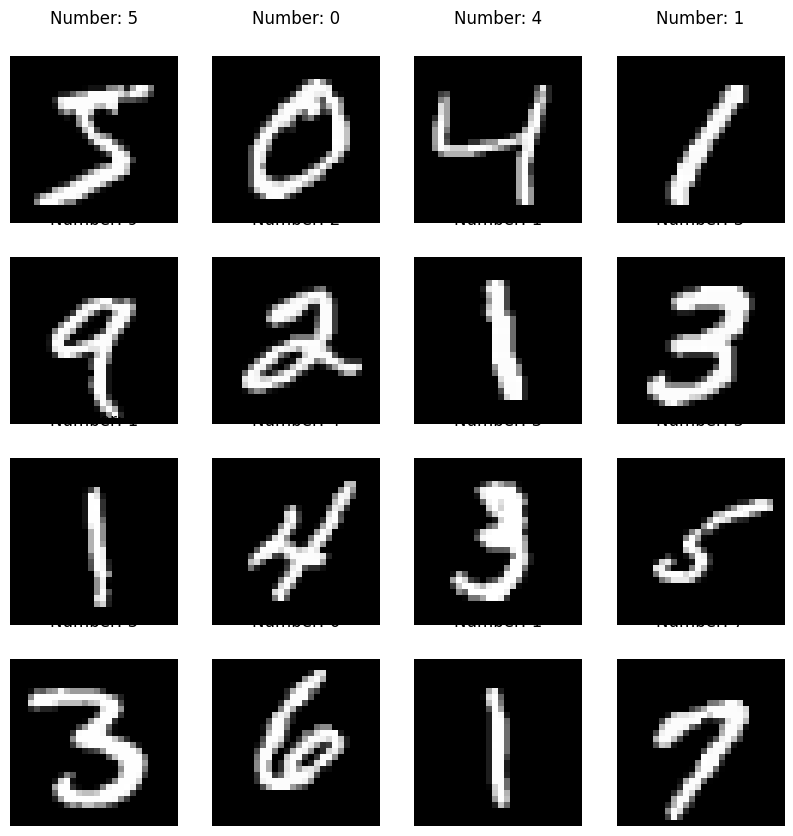

In [84]:
visualize_data(x_train, y_train)

# Preprocessing

In [85]:
# convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


# Kmean Clustering

In [86]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(n_clusters=10)

In [87]:
kmeans.labels_

array([0, 1, 4, ..., 0, 0, 6], dtype=int32)

# Assign Cluster Labels

In [88]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [89]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print (predicted_labels[:20])
print (Y[:20])

[6 0 9 1 4 2 1 8 1 4 6 1 3 6 1 7 2 8 6 4]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [90]:
accurate = np.sum(predicted_labels[:10000] == y_test[:10000]) / 10000
print(accurate)

0.1032


Optimize

In [91]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [92]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Inertia: 2373381.270294789
Homogeneity: 0.4485843636741595
Accuracy: 0.5456833333333333

Number of Clusters: 16
Inertia: 2219721.279314854
Homogeneity: 0.5230466259496038
Accuracy: 0.59445

Number of Clusters: 36
Inertia: 1950933.0273486935
Homogeneity: 0.6855957002818371
Accuracy: 0.7638833333333334

Number of Clusters: 64
Inertia: 1806408.7955224833
Homogeneity: 0.7507317146204738
Accuracy: 0.8276666666666667

Number of Clusters: 144
Inertia: 1623037.7286061752
Homogeneity: 0.805840530527599
Accuracy: 0.8656

Number of Clusters: 256
Inertia: 1505447.4894853812
Homogeneity: 0.843521075160818


KeyboardInterrupt: 

In [ ]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.9071



/tmp/ipykernel_11174/983761537.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


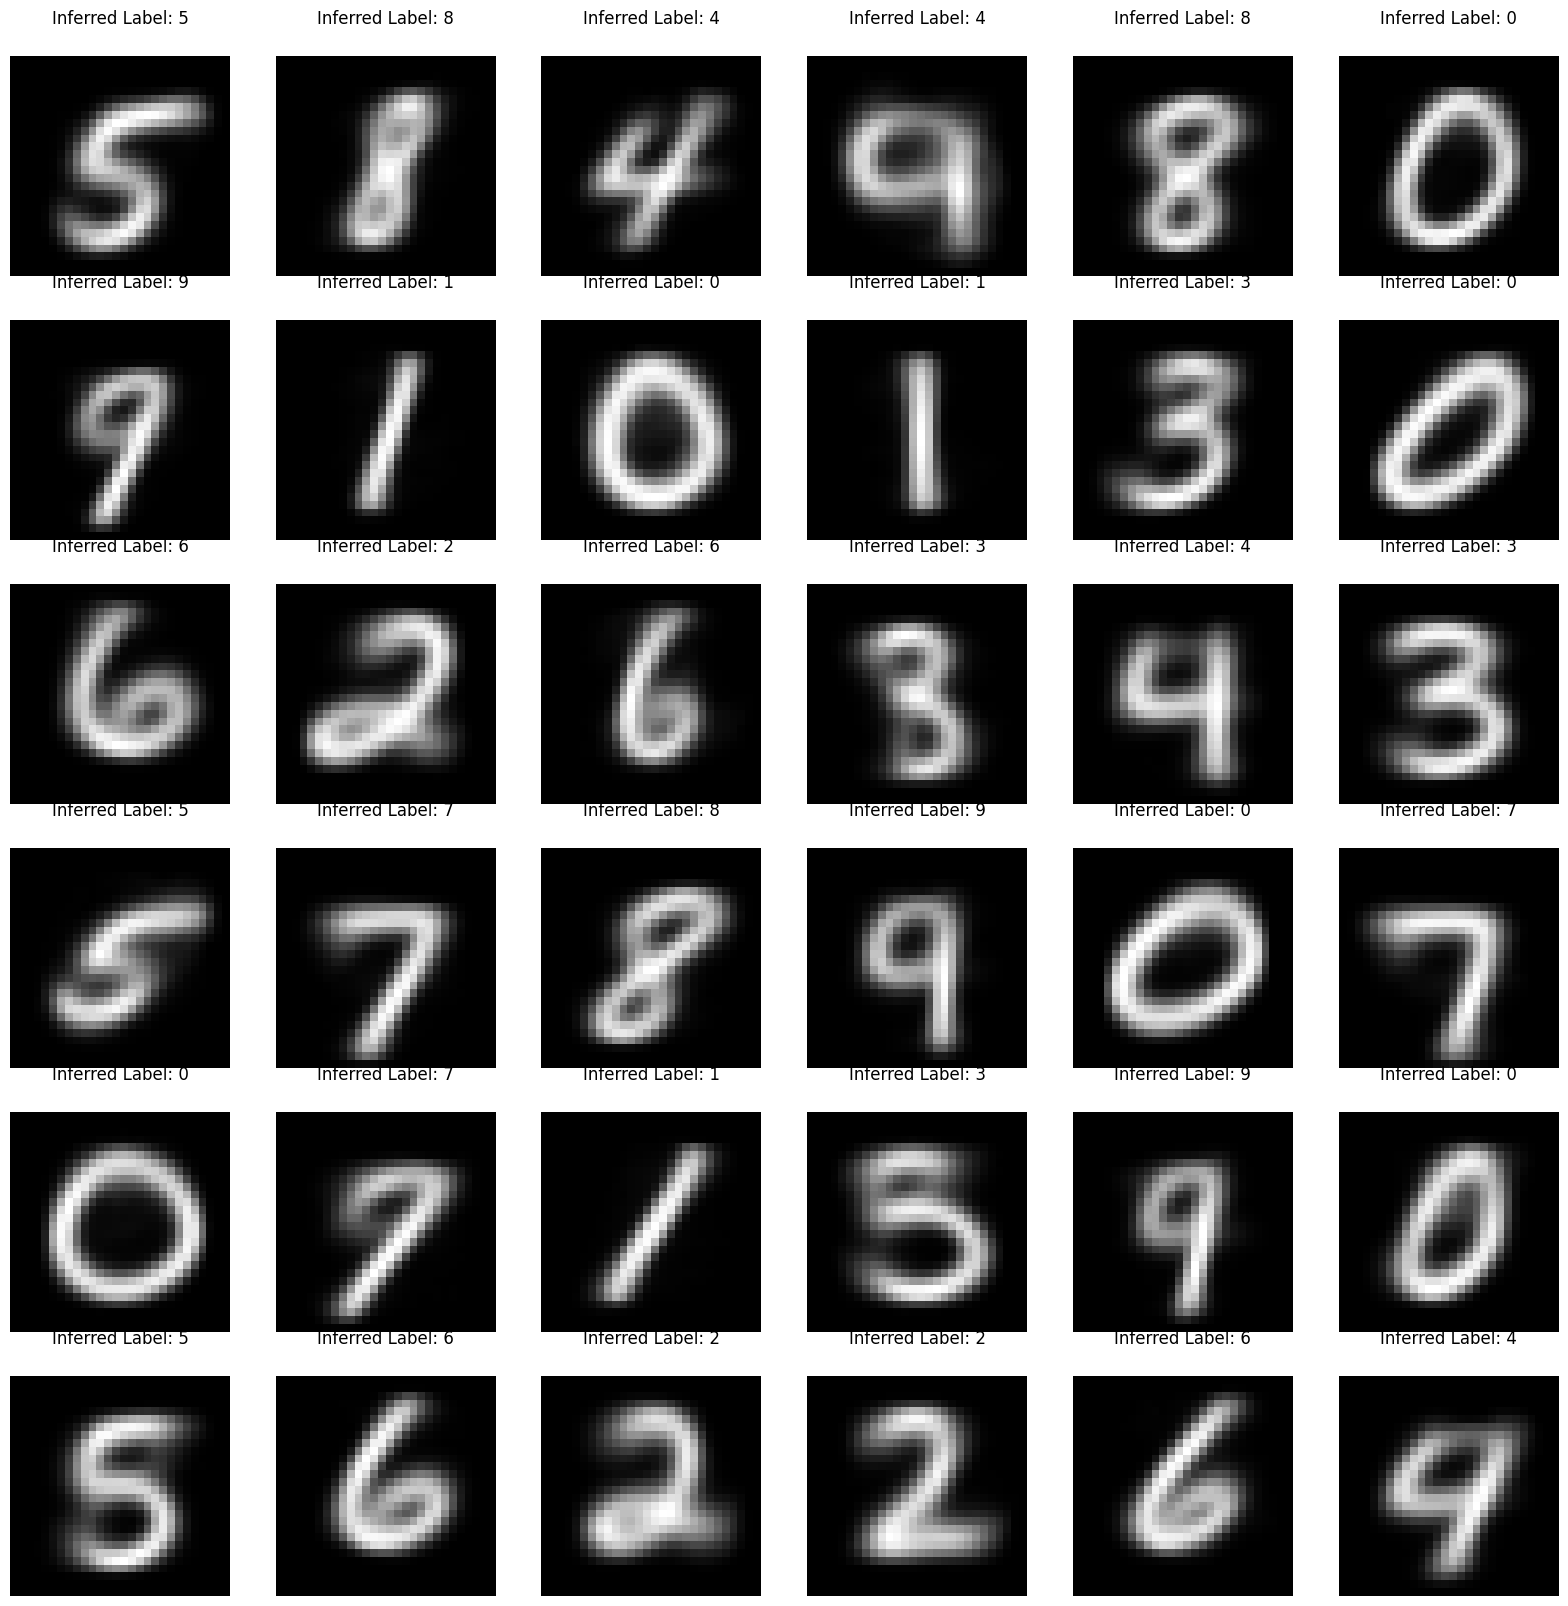

In [ ]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()